# Get stationary time series 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm
from random import seed
from cnn_graph.lib import models, graph, coarsening
from sklearn.metrics import r2_score, mean_squared_error

Using TensorFlow backend.


In [2]:
# Load data
dist_geo = pd.read_csv("data/distance_toulouse.csv",header=0,index_col=0)
X_hour = pd.read_csv("data/X_hour_toulouse.csv",header=0,index_col=0)
T_1, N = X_hour.shape
T_0 = int(T_1*0.85)
T_tv = int(T_0*0.9)

## weekly profile !only use the training set to get the profile!
X_train = X_hour.iloc[:T_tv,].copy()
index = np.tile(np.arange(1,24*7+1), np.int(X_hour.shape[0]/24/7)+1)[:X_hour.shape[0]] - 1
X_train['index'] = index[:T_tv]
wk_pf = X_train.groupby('index').mean()
X_train = X_train.drop(columns = "index")

X_hour, wk_pf = [np.float32(x) for x in [X_hour, wk_pf]]
X_hour_detrend = np.copy(X_hour) - wk_pf[index,:]

## Scale, to make the regularization parameter lambda have the same influence on all var.
X_train = X_hour_detrend[:T_tv,]
sd = X_train.std(axis = 0)
X_hour_detrend_sc = np.multiply(X_hour_detrend, 1/sd)

Text(0.5, 1.0, 'Stationary and scaled')

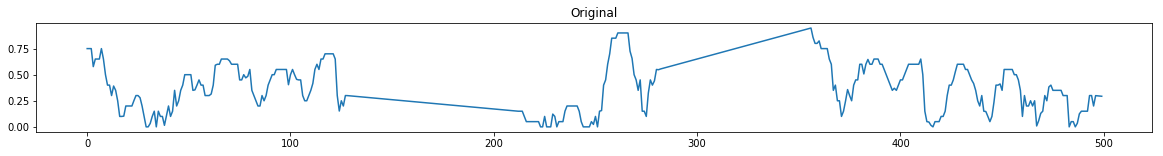

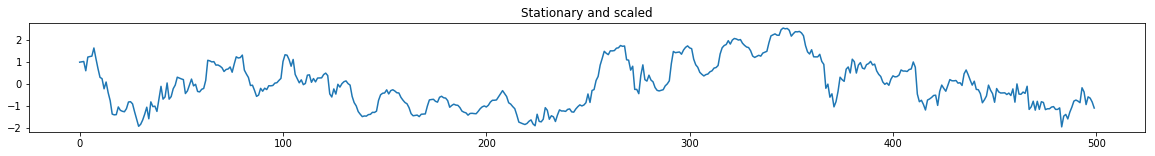

In [3]:
# Stationary and scaled time series
plt.rcParams["figure.figsize"] = (20,2)
plt.figure()
plt.plot(X_hour[:500,5])
plt.title('Original')
plt.figure()
plt.plot(X_hour_detrend_sc[:500,5])
plt.title('Stationary and scaled')

In [4]:
# Sampling size is given
P = int(0.1*N)
print(P)

# Time lag
H = 0

18


## Graph construction
the same as the one used in graph kernel approach

In [5]:
# Build the graph
k = 20 # nb of neighbours
dist, idx = graph.distance_sklearn_metrics(k = k, d = np.array(dist_geo))
A = graph.adjacency(dist, idx, k_self_tuning = 7).astype(np.float32)
graphs, perm = coarsening.coarsen(A, levels=0, self_connections=False) # No pooling used
L = [graph.laplacian(A, normalized=False) for A in graphs]

Layer 0: M_0 = |V| = 185 nodes (0 added),|E| = 2318 edges


## Network architecture

In [6]:
# GCN Architecture.
params = dict()
params['F']              = [16]  # Number of graph convolutional filters.
params['K']              = [50]  # Polynomial orders.
params['p']              = [1]   # Pooling sizes (1 is no pooling).
params['M']              = [128, 500, 64, N]  # Output dimensionality of fully connected layers.

In [7]:
# Selection hyperparameter (dropout rate at the input layer).
params['rate_input']     = P/N   # Rate of a input element being absent  

In [10]:
# Training.
params['dir_name']       = 'H0_select'
params['num_epochs']     = 500   # Max epochs. 
params['batch_size']     = 200 
params['learning_rate']  = 0.001

# Time lag.
params['H']              = H    

## Construct selection network

In [11]:
model = models.cgcnn(L, **params, selecting_mode = True, selecting_method = 'dropout')

NN architecture
  input: L_0 = 185
  layer 1: cgconv1
    representation: L_0 * F_1 / p_1 = 185 * 16 / 1 = 2960
    weights: F_0 * F_1 * K_1 = 1 * 16 * 50 = 800
    biases: L_1 * F_1 = 185 * 16 = 2960
  layer 2: fc1
    representation: L_2 = 128
    weights: L_1 * L_2 = 2960 * 128 = 378880
    biases: L_2 = 128
  layer 3: fc2
    representation: L_3 = 500
    weights: L_2 * L_3 = 128 * 500 = 64000
    biases: L_3 = 500
  layer 4: fc3
    representation: L_4 = 64
    weights: L_3 * L_4 = 500 * 64 = 32000
    biases: L_4 = 64
  layer 5: output
    representation: L_5 = 185
    weights: L_4 * L_5 = 64 * 185 = 11840
    biases: L_5 = 185
  Total number of trainable parameters: 491542
Gradient descent optimizer is being used in current selecting mode.


# Training selection network

In [12]:
# Input: All values of all sensors
X_train_H = np.empty((T_tv-H,     N, H+1))
X_val_H   = np.empty((T_0-T_tv-H, N, H+1))
for i in range(H+1):
    X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
    X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]

In [ ]:
losses_train, losses_val, scores, t_step = model.fit(train_data = X_train_H, train_targets = X_train_H[:,:,H], val_data = X_val_H, val_targets = X_val_H[:,:,H])

In [ ]:
# training curve
plt.rcParams["figure.figsize"] = (6,4)
fig = plt.figure()
plt.plot([x/losses_train[0] for x in losses_train], label = "train")
plt.plot([x/losses_val[0] for x in losses_val], label = "validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Reproduce the numerical results
Instead of the codes above for new training process, we can reproduce the numerical results reported in the paper. The four trained selection networks are saved in the folder **toulouse_H0_select_run1**, **toulouse_H0_select_run2**, **toulouse_H5_select_run1** and **toulouse_H5_select_run1**. To access the results, we need to first change the *dir_name* and *H* together with the data to input and output, second, reinitialize the model, then use model.evaluate directly on the data.

In [15]:
H = 0
params['dir_name']       = 'paris_H0_select_run1'
params['H']              = H

X_train_H = np.empty((T_tv-H,     N, H+1))
X_val_H   = np.empty((T_0-T_tv-H, N, H+1))
for i in range(H+1):
    X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
    X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]
    
model = models.cgcnn(L, **params, selecting_mode = True, selecting_method = 'dropout')

NN architecture
  input: L_0 = 185
  layer 1: cgconv1
    representation: L_0 * F_1 / p_1 = 185 * 16 / 1 = 2960
    weights: F_0 * F_1 * K_1 = 1 * 16 * 50 = 800
    biases: L_1 * F_1 = 185 * 16 = 2960
  layer 2: fc1
    representation: L_2 = 128
    weights: L_1 * L_2 = 2960 * 128 = 378880
    biases: L_2 = 128
  layer 3: fc2
    representation: L_3 = 500
    weights: L_2 * L_3 = 128 * 500 = 64000
    biases: L_3 = 500
  layer 4: fc3
    representation: L_4 = 64
    weights: L_3 * L_4 = 500 * 64 = 32000
    biases: L_4 = 64
  layer 5: output
    representation: L_5 = 185
    weights: L_4 * L_5 = 64 * 185 = 11840
    biases: L_5 = 185
  Total number of trainable parameters: 491542
Gradient descent optimizer is being used in current selecting mode.


## Scoring the learned sensor predictability

In [16]:
Y_val = X_val_H[:,:,H]
_,Y_pred,_,_ = model.evaluate(X_val_H, Y_val)
r2 = r2_score(Y_val,Y_pred, multioutput = 'raw_values') 
mse = mean_squared_error(Y_val,Y_pred, multioutput = 'raw_values') 

INFO:tensorflow:Restoring parameters from /Users/yiye/Desktop/velib Toulouse/tasks/cnn_graph/lib/../checkpoints/Velib_predictor_H0_select_test1/model-4080


## Selection results

In [17]:
I_r2 = np.argsort(-r2)[:P]
I_mse = np.argsort(mse)[:P]
print(I_r2)
print(I_mse)

[ 11  74  26  77 139  24  72  60 140  41   0  63 151  15 147 166  64   6]
[163 177 167 166 125 184 168 120  51  66  31 129 170 124   6 139 128 143]


## Outputs of the trained selection net

In [18]:
# The output of selection network trained by the dropout strategy
# Visualize in the original data scale
Y_pred = np.multiply(Y_pred, sd) # Multiply the std back
Y_pred += wk_pf[index[T_tv+H:T_0],:] # Add the trend back

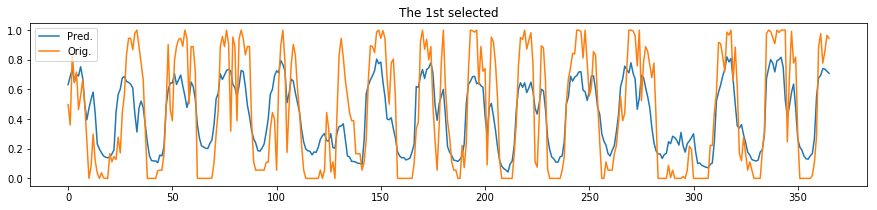

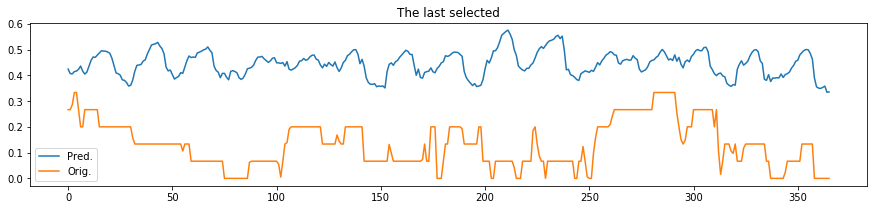

In [19]:
plt.ion()
plt.rcParams["figure.figsize"] = (15,3)
fig = plt.figure()
plt.plot(Y_pred[:,I_r2[0]], label = 'Pred.')
plt.plot(X_hour[T_tv+H:T_0,I_r2[0]], label = 'Orig.')
plt.title('The 1st selected')
plt.legend()
fig = plt.figure()
plt.plot(Y_pred[:,np.argsort(-r2)[-1]], label = 'Pred.')
plt.plot(X_hour[T_tv+H:T_0,np.argsort(-r2)[-1]], label = 'Orig.')
plt.title('The last selected')
plt.legend()

# Reconstruction performance on test set
## Construct prediction network

In [20]:
# Change some settings to construct the prediction network
params['dir_name']       = 'H0_reconstruct'
params['batch_size']     = 2000
params['num_epochs']     = 50
params['M'][-1]          = P # Output dimension
params['learning_rate']  = 0.001

In [21]:
model = models.cgcnn(L, **params, selecting_mode = False)

NN architecture
  input: L_0 = 185
  layer 1: cgconv1
    representation: L_0 * F_1 / p_1 = 185 * 16 / 1 = 2960
    weights: F_0 * F_1 * K_1 = 1 * 16 * 50 = 800
    biases: L_1 * F_1 = 185 * 16 = 2960
  layer 2: fc1
    representation: L_2 = 128
    weights: L_1 * L_2 = 2960 * 128 = 378880
    biases: L_2 = 128
  layer 3: fc2
    representation: L_3 = 500
    weights: L_2 * L_3 = 128 * 500 = 64000
    biases: L_3 = 500
  layer 4: fc3
    representation: L_4 = 64
    weights: L_3 * L_4 = 500 * 64 = 32000
    biases: L_4 = 64
  layer 5: output
    representation: L_5 = 18
    weights: L_4 * L_5 = 64 * 18 = 1152
    biases: L_5 = 18
  Total number of trainable parameters: 480687
Adam optimizer is being used.


In [22]:
I = I_r2

X_train_H = np.empty((T_tv-H,     N, H+1))
X_val_H   = np.empty((T_0-T_tv-H, N, H+1))
X_test_H  = np.empty((T_1-T_0-H,  N, H+1))
for i in range(H+1):
    X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
    X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]
    X_test_H[:,:,H-i]  = X_hour_detrend_sc[(T_0+H-i):(T_1-i),:]
    
Y_train = np.copy(X_train_H[:,I,H])
X_train_H[:,I,:] = 0.0
Y_val = np.copy(X_val_H[:,I,H])
X_val_H[:,I,:] = 0.0
Y_test = np.copy(X_test_H[:,I,H])
X_test_H[:,I,:] = 0.0

In [24]:
err_mse0 = np.zeros(2)
for x in range(2):
    _, _, _, _ = model.fit(train_data = X_train_H, train_targets = Y_train, val_data = X_val_H, val_targets = Y_val)
    _,Y_pred,_,_ = model.evaluate(X_test_H, Y_test)
    # The reconstruction error on test set
    err_mse0[x] = norm(Y_test - Y_pred)**2/Y_pred.shape[0]
    print(err_mse0[x])

epoch 1 :
  training_loss = 8.71e+00
  validation r2: -0.04, loss: 8.90e+00
  time: 3s (wall 2s)
epoch 2 :
  training_loss = 8.30e+00
  validation r2: -0.03, loss: 8.78e+00
  time: 6s (wall 3s)
epoch 3 :
  training_loss = 7.94e+00
  validation r2: -0.01, loss: 8.63e+00
  time: 8s (wall 4s)
epoch 4 :
  training_loss = 7.54e+00
  validation r2: 0.00, loss: 8.50e+00
  time: 11s (wall 5s)
epoch 5 :
  training_loss = 7.03e+00
  validation r2: 0.01, loss: 8.44e+00
  time: 13s (wall 6s)
epoch 6 :
  training_loss = 6.69e+00
  validation r2: -0.01, loss: 8.51e+00
  time: 16s (wall 7s)
epoch 7 :
  training_loss = 6.44e+00
  validation r2: -0.03, loss: 8.62e+00
  time: 18s (wall 8s)
 Training stopped for the validation loss starts to increase.
validation score: peak = 0.01, mean = -0.01
validation loss: min = 8.44, mean = 8.54
INFO:tensorflow:Restoring parameters from /Users/yiye/Desktop/velib Toulouse/tasks/cnn_graph/lib/../checkpoints/H0_reconstruct/model-7
16.902043792458475
epoch 1 :
  traini

In [25]:
err_mse0.mean()

16.70807224503006

In [26]:
# Get the predictions of the original time series
Y_pred = np.multiply(Y_pred, sd[I]) # Multiply the std back
Y_pred += wk_pf[index[T_0+H:],:][:,I] # Add the trend back

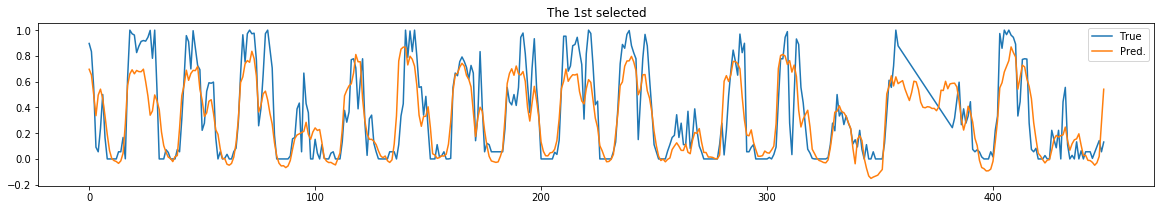

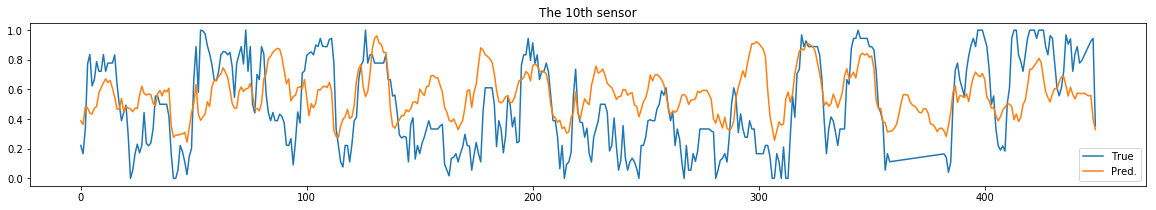

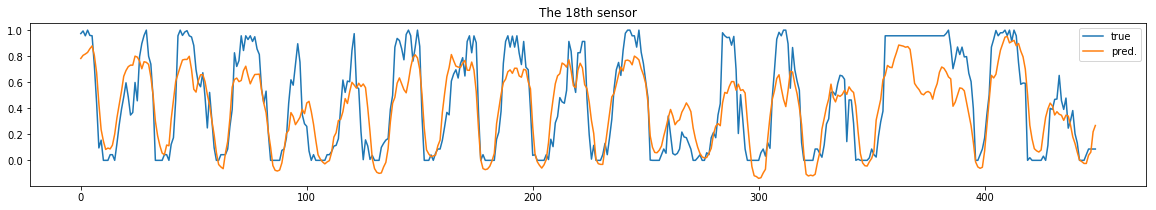

In [27]:
plt.ion()
x = 450
plt.rcParams["figure.figsize"] = (20,3)
fig = plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I][:,0], label = 'True')
plt.plot(Y_pred[:x,0], label = 'Pred.')
plt.title('The 1st selected')
plt.legend()
fig = plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I][:,int(P/2)], label = 'True')
plt.plot(Y_pred[:x,int(P/2)], label = 'Pred.')
plt.title("The {}th sensor".format(int(P/2)+1))
plt.legend()
plt.figure()
plt.plot(X_hour[T_0+H:T_0+H+x,][:,I][:,P-1], label = "true")
plt.plot(Y_pred[:x,P-1], label = "pred.")
plt.title("The {}th sensor".format(P))
plt.legend()

# Comparison with random sampling 

In [36]:
err_mse0 = np.zeros(10)
for x in range(10):
    I_rand = np.random.choice(N, P, replace=False)
    for i in range(H+1):
        X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
        X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]
        X_test_H[:,:,H-i]  = X_hour_detrend_sc[(T_0+H-i):(T_1-i),:]
    
    Y_train = np.copy(X_train_H[:,I_rand,H])
    X_train_H[:,I_rand,:] = 0.0
    Y_val = np.copy(X_val_H[:,I_rand,H])
    X_val_H[:,I_rand,:] = 0.0
    Y_test = np.copy(X_test_H[:,I_rand,H])
    X_test_H[:,I_rand,:] = 0.0
    
    _, _, _, _ = model.fit(train_data = X_train_H, train_targets = Y_train, val_data = X_val_H, val_targets = Y_val)
    _,Y_pred,_,_ = model.evaluate(X_test_H, Y_test)
    # The reconstruction error on test set
    err_mse0[x] = norm(Y_test - Y_pred)**2/Y_pred.shape[0]
    print(err_mse0[x])

epoch 1 :
  training_loss = 8.86e+00
  validation r2: -0.56, loss: 1.42e+01
  time: 3s (wall 2s)
epoch 2 :
  training_loss = 8.63e+00
  validation r2: -0.54, loss: 1.41e+01
  time: 6s (wall 3s)
epoch 3 :
  training_loss = 8.43e+00
  validation r2: -0.53, loss: 1.40e+01
  time: 8s (wall 4s)
epoch 4 :
  training_loss = 8.15e+00
  validation r2: -0.52, loss: 1.39e+01
  time: 11s (wall 5s)
epoch 5 :
  training_loss = 7.89e+00
  validation r2: -0.51, loss: 1.38e+01
  time: 13s (wall 6s)
epoch 6 :
  training_loss = 7.52e+00
  validation r2: -0.52, loss: 1.38e+01
  time: 16s (wall 7s)
epoch 7 :
  training_loss = 7.09e+00
  validation r2: -0.53, loss: 1.38e+01
  time: 18s (wall 8s)
epoch 8 :
  training_loss = 6.67e+00
  validation r2: -0.55, loss: 1.39e+01
  time: 21s (wall 9s)
 Training stopped for the validation loss starts to increase.
validation score: peak = -0.51, mean = -0.53
validation loss: min = 13.81, mean = 13.86
INFO:tensorflow:Restoring parameters from /Users/yiye/Desktop/velib T

  validation r2: -0.44, loss: 1.22e+01
  time: 3s (wall 1s)
epoch 2 :
  training_loss = 8.51e+00
  validation r2: -0.43, loss: 1.22e+01
  time: 6s (wall 2s)
epoch 3 :
  training_loss = 8.25e+00
  validation r2: -0.42, loss: 1.22e+01
  time: 8s (wall 3s)
epoch 4 :
  training_loss = 7.89e+00
  validation r2: -0.41, loss: 1.21e+01
  time: 11s (wall 4s)
epoch 5 :
  training_loss = 7.57e+00
  validation r2: -0.39, loss: 1.21e+01
  time: 13s (wall 5s)
epoch 6 :
  training_loss = 7.10e+00
  validation r2: -0.39, loss: 1.21e+01
  time: 16s (wall 6s)
epoch 7 :
  training_loss = 6.79e+00
  validation r2: -0.39, loss: 1.21e+01
  time: 18s (wall 8s)
epoch 8 :
  training_loss = 6.29e+00
  validation r2: -0.40, loss: 1.21e+01
  time: 21s (wall 9s)
epoch 9 :
  training_loss = 5.91e+00
  validation r2: -0.42, loss: 1.21e+01
  time: 23s (wall 10s)
 Training stopped for the validation loss starts to increase.
validation score: peak = -0.39, mean = -0.40
validation loss: min = 12.05, mean = 12.07
INFO:te

In [37]:
err_mse0.mean()

22.645872202687052